In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import math
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [2]:
df = yf.download("BTC-USD")

[*********************100%***********************]  1 of 1 completed


In [3]:
sequence = df['Adj Close'].to_frame()

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
scaled= sc.fit_transform(sequence)
scaled

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.35015447],
       [0.33628824],
       [0.338964  ]])

In [5]:
sequence= scaled
sequence

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.35015447],
       [0.33628824],
       [0.338964  ]])

In [6]:
n = len(sequence)
train_ratio = 0.8
train = sequence[:int(train_ratio * n)]
test = sequence[int(train_ratio * n):]

In [7]:
timestep = 10
x_train, y_train = [], []
for i in range(timestep, len(train)):
    x_train.append(train[i - timestep:i])
    y_train.append(train[i])

x_test, y_test = [], []
for i in range(timestep, len(test)):
    x_test.append(test[i - timestep:i])
    y_test.append(test[i])

In [8]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [9]:
model =Sequential([LSTM(units=100, input_shape=(timestep, 1)),Dense(1)])
model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [11]:
model.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
77/77 [==============================] - 2s 5ms/step - loss: 0.0029
Epoch 2/100
77/77 [==============================] - 0s 5ms/step - loss: 3.8490e-04
Epoch 3/100
77/77 [==============================] - 0s 5ms/step - loss: 3.5107e-04
Epoch 4/100
77/77 [==============================] - 0s 5ms/step - loss: 3.3852e-04
Epoch 5/100
77/77 [==============================] - 0s 5ms/step - loss: 3.0141e-04
Epoch 6/100
77/77 [==============================] - 0s 5ms/step - loss: 2.9168e-04
Epoch 7/100
77/77 [==============================] - 0s 5ms/step - loss: 2.6239e-04
Epoch 8/100
77/77 [==============================] - 0s 5ms/step - loss: 2.7954e-04
Epoch 9/100
77/77 [==============================] - 0s 5ms/step - loss: 2.5555e-04
Epoch 10/100
77/77 [==============================] - 0s 5ms/step - loss: 2.2662e-04
Epoch 11/100
77/77 [==============================] - 0s 5ms/step - loss: 2.4245e-04
Epoch 12/100
77/77 [==============================] - 0s 5ms/step - loss: 2.23

In [15]:
import matplotlib.pyplot as plt

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

19/19 [==============================] - 0s 2ms/step


In [16]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

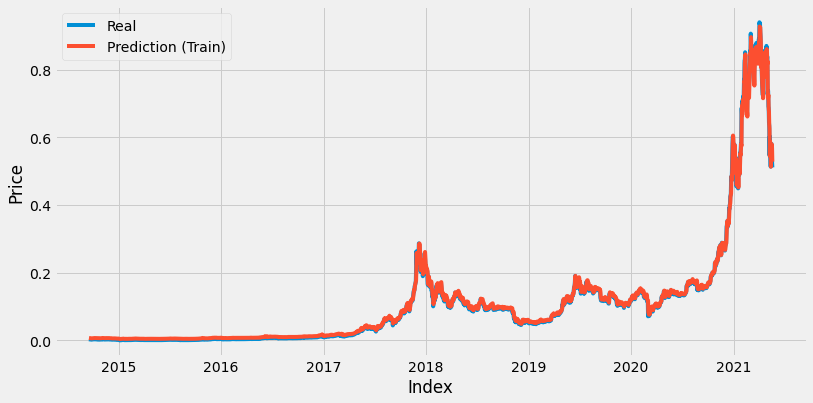

In [17]:
plt.figure(figsize=(12,6))
plt.plot(df.index[:len(y_train)], y_train, label='Real')
plt.plot(df.index[:len(y_pred_train)], y_pred_train, label='Prediction (Train)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

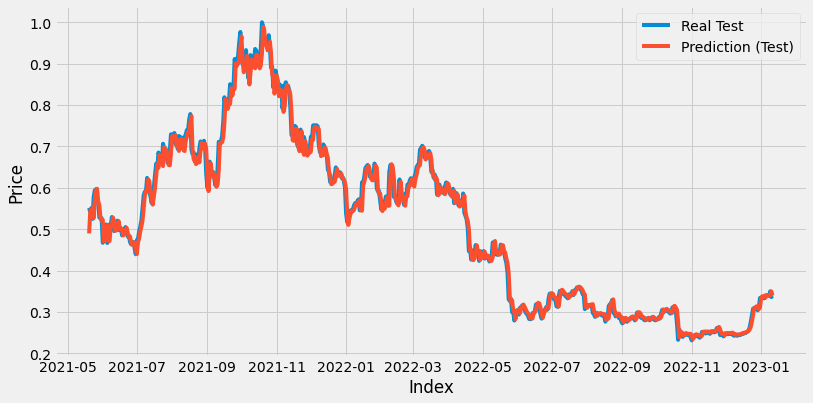

In [18]:
start_index = len(y_train)
end_index = start_index + len(y_test)
plt.figure(figsize=(12,6))
plt.plot(df.index[start_index:end_index], y_test, label='Real Test')
plt.plot(df.index[start_index:end_index], y_pred_test, label='Prediction (Test)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

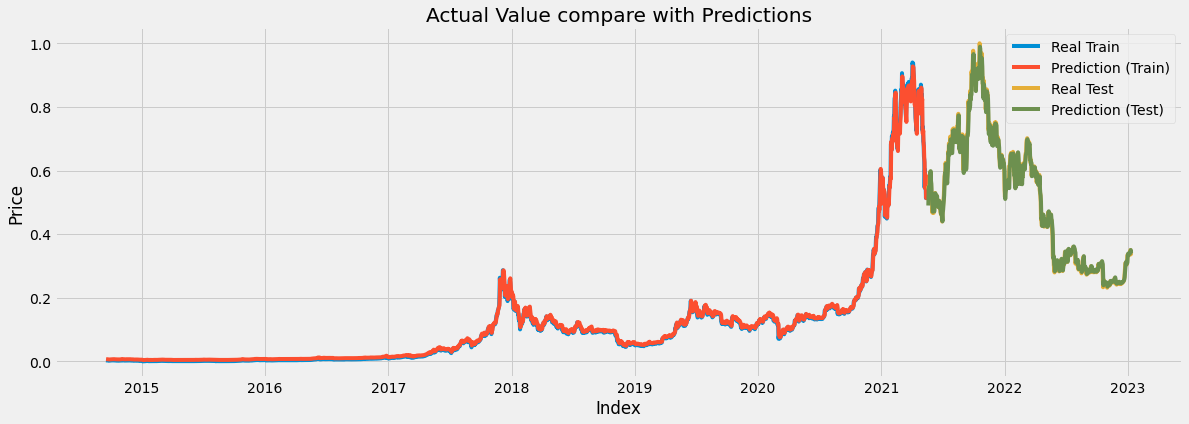

In [19]:
plt.figure(figsize=(18,6))
plt.plot(df.index[:len(y_train)], y_train, label='Real Train')
plt.plot(df.index[:len(y_pred_train)], y_pred_train, label='Prediction (Train)')
start_index = len(y_train)
end_index = start_index + len(y_test)
plt.plot(df.index[start_index:end_index], y_test, label='Real Test')
plt.plot(df.index[start_index:end_index], y_pred_test, label='Prediction (Test)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.title('Actual Value compare with Predictions')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse= mean_squared_error(y_pred_test, y_test)
rmse=sqrt(mse)
print('MSE LSTM: %.2f' % mse)
print('RMSE LSTM: %.2f' % rmse)

MSE LSTM: 0.00
RMSE LSTM: 0.02


In [21]:
# Tính toán dữ liệu đầu vào cho 6 tháng tiếp theo
from datetime import timedelta
last_6month = y_test[-180:]
input_data = []
for i in range(len(last_6month) - timestep):
    input_data.append(last_6month[i:i + timestep])
input_data = np.array(input_data).reshape(-1, timestep, 1)

# Dự đoán giá trị 6 tháng tiếp theo
y_pred_6month = model.predict(input_data)

# Tạo DataFrame cho dữ liệu dự đoán
df_pred_6month = pd.DataFrame({'Price': y_pred_6month.flatten()})

# Tạo cột "Date" tương ứng với dữ liệu dự đoán
last_date = df.index[-1]
df_pred_6month['Date'] = [last_date + timedelta(days=i) for i in range(1, len(df_pred_6month) + 1)]

6/6 [==============================] - 0s 3ms/step


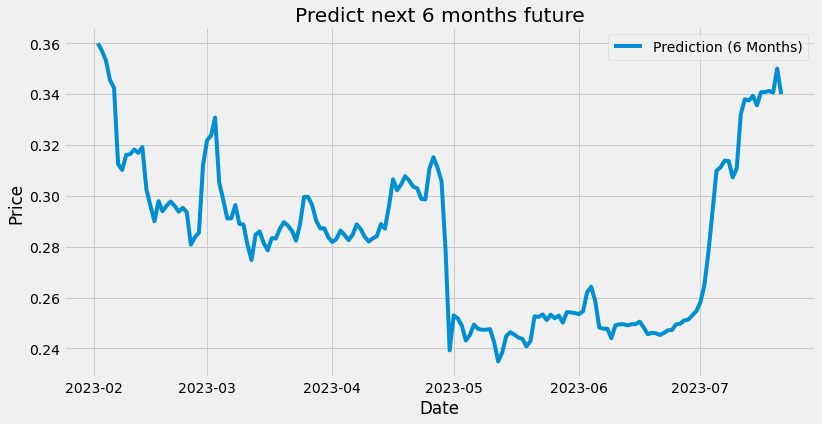

In [22]:
# Vẽ hình
plt.figure(figsize=(12,6))
plt.plot(df_pred_6month['Date'], df_pred_6month['Price'], label='Prediction (6 Months)')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title('Predict next 6 months future')
plt.legend()
plt.show()

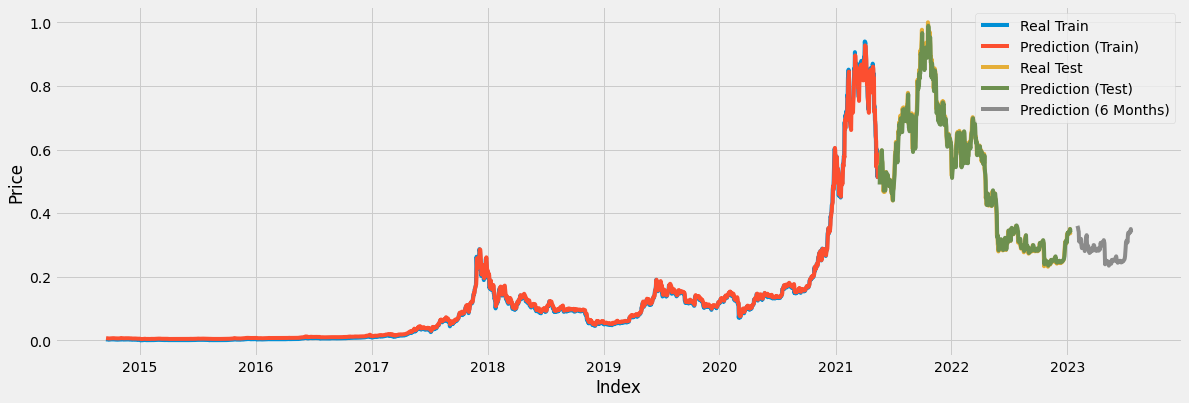

In [23]:
plt.figure(figsize=(18,6))
plt.plot(df.index[:len(y_train)], y_train, label='Real Train')
plt.plot(df.index[:len(y_pred_train)], y_pred_train, label='Prediction (Train)')
start_index = len(y_train)
end_index = start_index + len(y_test)
plt.plot(df.index[start_index:end_index], y_test, label='Real Test')
plt.plot(df.index[start_index:end_index], y_pred_test, label='Prediction (Test)')
plt.plot(df_pred_6month['Date'], df_pred_6month['Price'], label='Prediction (6 Months)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

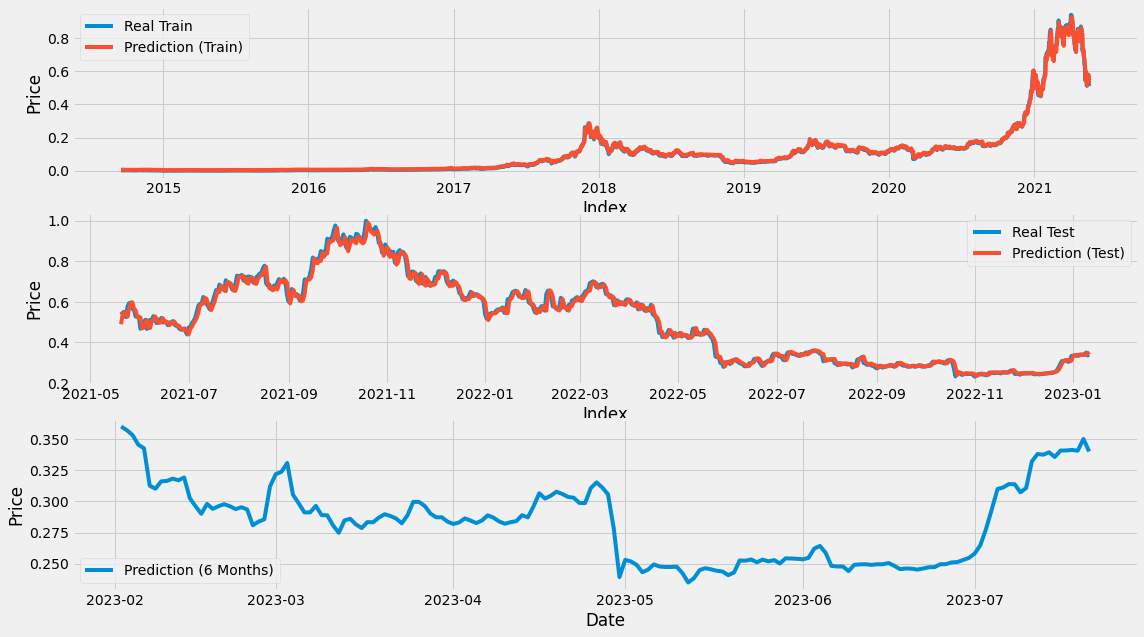

In [24]:
plt.figure(figsize=(17,10))

plt.subplot(3,1,1)
plt.plot(df.index[:len(y_train)], y_train, label='Real Train')
plt.plot(df.index[:len(y_pred_train)], y_pred_train, label='Prediction (Train)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

plt.subplot(3,1,2)
start_index = len(y_train)
end_index = start_index + len(y_test)
plt.plot(df.index[start_index:end_index], y_test, label='Real Test')
plt.plot(df.index[start_index:end_index], y_pred_test, label='Prediction (Test)')
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

plt.subplot(3,1,3)
plt.plot(df_pred_6month['Date'], df_pred_6month['Price'], label='Prediction (6 Months)')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

plt.show()